# Analyze RAGIS scalar timeseries

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os
import re
from pathlib import Path

import seaborn as sns

from pism_ragis.observations import load_imbie, load_mouginot
from pism_ragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pism_ragis.processing import convert_netcdf_to_dataframe, check_file, copy_file, ncfile2dataframe
from pism_ragis.stats import run_stats

In [11]:
n_jobs = 2
norm_year = 1992.0

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"


bg_color = "#216779"
bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#sim_colors = ["#882255", "#AA4499", "#CC6677", "#DDCC77", "#88CCEE", "#44AA99", "#117733", "#332288"]
imbie_color = "k"
imbie_color = "#238b45"
mou_color = "#6a51a3"
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2

## Load IMBIE

In [9]:
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 35 * gt2cmsle
imbie[smb_varname] += 35

In [4]:
mou = load_mouginot(url=Path("/mnt/storstrommen/ragis/data/mouginot/pnas.1904242116.sd02.xlsx"), norm_year=1980)
mou_gis = mou[mou["Basin"] == "GIS"]

mou_1992 = load_mouginot(url=Path("/mnt/storstrommen/ragis/data/mouginot/pnas.1904242116.sd02.xlsx"), norm_year=1992)
mou_gis_1992 = mou_1992[mou_1992["Basin"] == "GIS"]

# man = load_mankoff(Path("/mnt/storstrommen/ragis/data/mankoff/MB_SMB_D_BMB.csv"))

/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWar

## Make a list of all experiments

In [5]:
data_dir = "/mnt/storstrommen/ragis/data/pism/"

sims = {
    "no frontal melt": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
    "with frontal melt": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-1-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
}

# sims = {
#     "CTRL VCM-0.40": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.40-S-0_1980-1-1_2020-1-1.nc"),
#     "CTRL VCM-0.41": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.41-S-0_1980-1-1_2020-1-1.nc"),
#     "FM VCM-0.40": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-1-VCM-0.40-S-0_1980-1-1_2020-1-1.nc"),
#     "FM VCM-0.45": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-1-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
# }

# sims = {
#     "RAGIS VCM-0.40": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.40-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.41": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.41-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.42": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.42-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.45": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
#     "GIMP VCM-0.41": os.path.join(data_dir, "2023_08_gimp_tillwat/scalar/ts_gris_g900m_v2023_GIMP_id_FM-0-VCM-0.41-S-0_1980-1-1_2020-1-1.nc"),
#     "GIMP VCM-0.42": os.path.join(data_dir, "2023_08_gimp_tillwat/scalar/ts_gris_g900m_v2023_GIMP_id_FM-0-VCM-0.42-S-0_1980-1-1_2020-1-1.nc"),
#     "GIMP VCM-0.45": os.path.join(data_dir, "2023_08_gimp_tillwat/scalar/ts_gris_g900m_v2023_GIMP_id_FM-0-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
# }

sims = {
    "RAGIS Unconstrained": os.path.join(data_dir, "2024_02_ragis/scalar/ts_gris_g900m_v2024-02_RAGIS_id_BAYES-MEDIAN_1980-1-1_2020-1-1.nc"),
    "RAGIS Constrained": os.path.join(data_dir, "2024_02_ragis/scalar/ts_gris_g900m_v2024-02_RAGIS_id_BAYES-MEDIAN-FR-OFF_1980-1-1_2020-1-1.nc"),
    "RAGIS Unconstrained TW": os.path.join(data_dir, "2024_02_ragis_tw/scalar/ts_gris_g900m_v2024-02_RAGIS_id_BAYES-MEDIAN_1980-1-1_2020-1-1.nc"),
    "RAGIS Constrained TW": os.path.join(data_dir, "2024_02_ragis_tw/scalar/ts_gris_g900m_v2024-02_RAGIS_id_BAYES-MEDIAN-FR-OFF_1980-1-1_2020-1-1.nc"),
#    "GrIMP Unconstrained": os.path.join(data_dir, "2024_02_grimp/scalar/ts_gris_g900m_v2023_GRIMP_id_BAYES-MEDIAN_1980-1-1_2020-1-1.nc"),
#    "GrIMP Constrained": os.path.join(data_dir, "2024_02_grimp/scalar/ts_gris_g900m_v2023_GRIMP_id_BAYES-MEDIAN-FR-OFF_1980-1-1_2020-1-1.nc"),
}




## Process experiments

In [6]:


exp_dfs = []
for sim_key, sim_val in sims.items():
    df = ncfile2dataframe(sim_val, resample="yearly", norm_year=1992)
    exp_dfs.append(df)


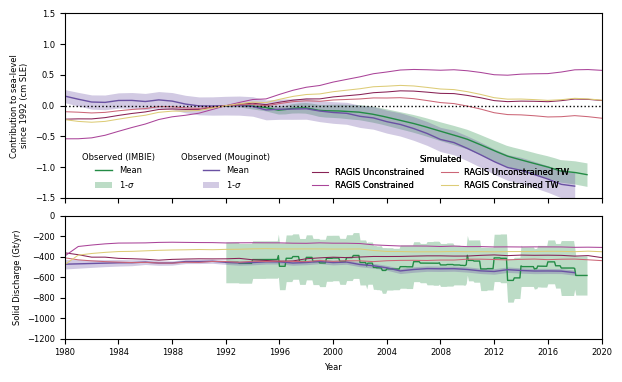

In [7]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.8), height_ratios=[3, 2])
fig.subplots_adjust(wspace=-0.5, hspace=-0.5)

for obs, o, obs_color, obs_loc  in zip([imbie, mou_gis_1992], ["IMBIE", "Mouginot"], 
                                       [imbie_color, mou_color], [(0.1, 0.0), (0.3, 0.0)]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30, label="1-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30)
    obs_line = axs[0].plot(obs["Date"], obs[mass_varname], color=obs_color, lw=1, label="Mean")
    axs[1].plot(obs["Date"], obs[discharge_varname], color=obs_color, lw=1)

    legend_obs = axs[0].legend(handles=[obs_line[0], obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title=f"Observed ({o})")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sim_handles = []
sim_labels = []
for k, exp in enumerate(exp_dfs):
    sim_label = list(sims.keys())[k]
    sim_handle = axs[0].plot(exp["time"], -exp[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(exp["time"], -exp[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sim_handles.append(sim_handle[0])
    sim_labels.append(sim_label)


fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.5, 1.5)
axs[1].set_ylim(-1200, 0)


legend_sim = axs[0].legend(handles=sim_handles, labels=sim_labels, loc="lower center", bbox_to_anchor=(0.7, 0.0), 
                           ncols=2, title="Simulated")
legend_sim.get_frame().set_linewidth(0.0)
legend_sim.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sim)

fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf

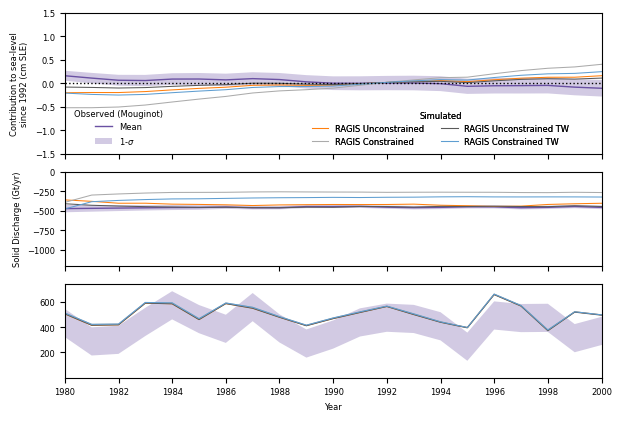

In [14]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(6.2, 4.2), height_ratios=[3, 2, 2])
fig.subplots_adjust(wspace=-0.5, hspace=-0.5)

for obs, o, obs_color, obs_loc  in zip([mou_gis_1992], ["Mouginot"], 
                                      [mou_color], [(0.1, 0.0)]):
# for obs, o, obs_color, obs_loc  in zip([imbie, mou_gis_1992], ["IMBIE", "Mouginot"], 
#                                       [imbie_color, mou_color], [(0.1, 0.0), (0.3, 0.0)]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30, label="1-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30)
    axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30)    
    obs_line = axs[0].plot(obs["Date"], obs[mass_varname], color=obs_color, lw=1, label="Mean")
    axs[1].plot(obs["Date"], obs[discharge_varname], color=obs_color, lw=1)

    legend_obs = axs[0].legend(handles=[obs_line[0], obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title=f"Observed ({o})")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sim_handles = []
sim_labels = []
for k, exp in enumerate(exp_dfs):
    sim_label = list(sims.keys())[k]
    sim_handle = axs[0].plot(exp["time"], -exp[mass_varname] -(imbie[smb_varname] - exp[smb_varname]).mean()  * gt2cmsle, color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(exp["time"], -exp[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[2].plot(exp["time"], exp[smb_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sim_handles.append(sim_handle[0])
    sim_labels.append(sim_label)


fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
axs[0].set_ylim(-1.5, 1.5)
axs[1].set_ylim(-1200, 0)


legend_sim = axs[0].legend(handles=sim_handles, labels=sim_labels, loc="lower center", bbox_to_anchor=(0.7, 0.0), 
                           ncols=2, title="Simulated")
legend_sim.get_frame().set_linewidth(0.0)
legend_sim.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sim)

fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf

In [79]:
(25.66-25.29) / 25.39 * 100

1.457266640409614

In [80]:
kg2cmsle = 1 / 362.5 / 1e12 / 10

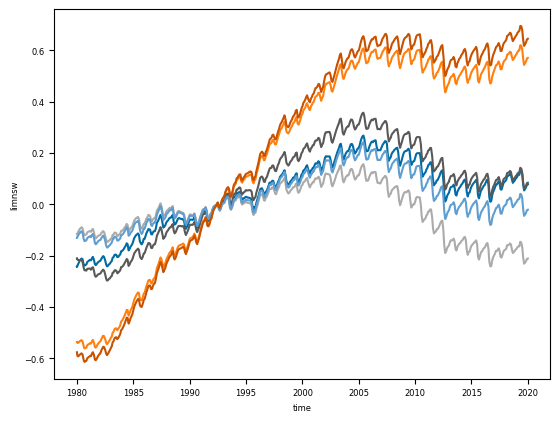

In [46]:
for sim_key, sim_val in sims.items():
    ds = xr.open_dataset(sim_val)
    sle = (ds["limnsw"] - ds["limnsw"].sel(time="1992-6-1", method="nearest")) * kg2cmsle
    sle.plot()

In [74]:
(imbie[smb_varname] - exp[smb_varname]).mean()  

-52.01320874402735